# **Time Series e Guia do Mochileiro das Galáxias**

Primeiramente... **DON'T PANIC !!!** 

Segundamente, tentarei auxiliar uma empresa a compreender o comportamento das vendas, como se enfiassem um Peixe-Babel no ouvido...

Este projeto consiste em responder algumas dúvidas básicas sobre as vendas de uma determinada empresa na galáxia, tais como:
*   Total de vendas por ano;
*   Total de vendas por produto e planeta;
*   Time Series do total de vendas por planeta e produto por ano-semana;
*   Total de vendas do Deep Thought em Marte de 2015-20 a 2018-22.

Será seguido uma metodologia a fim de trazer uma melhor compreensão e ordem dos processos, além de melhor objetividade e clareza nos resultados obtidos.

<br>

__________________

# Metodologia
A metodologia que tentará ser seguida neste projeto é a metodologia CRISP-DM pois é adaptada para um projeto que envolda ciência de dados. Esta metodologia foi criada pelos seres mais inteligentes da Terra: os ratos. 

Para mais detalhes acesse [CRISP DM](https://https://www.datascience-pm.com/crisp-dm-2/).

<br>

<img src = "https://user-images.githubusercontent.com/56659549/140829277-ff95f212-c349-4eda-bd01-469f9a8e8b69.jpg" width = 400>

<br>
<br>

_______________________

# 1) Imports

Primeiro passo trata-se da importação das bibliotecas necessárias e das configurações preliminares.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 2) Carregando os Dados

In [ ]:
sales = pd.read_csv('data.csv')
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29580 entries, 0 to 29579
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     29580 non-null  object
 1   geocode  29580 non-null  int64 
 2   price    29580 non-null  int64 
 3   planet   29580 non-null  object
 4   product  29580 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.1+ MB


# 3) Preparação dos Dados
Nesta etapa será feita uma análise superficial dos dados, visualizando-o e preparando-o para as próximas análises e para a visualização e mineração de dados. É uma etapa muito importante.

Após uma rápida observação, será então iniciada a limpeza e tratamento dos dados para que se adequem ideal para serem trabalhados.

In [ ]:
sales.sample(10)

,date,geocode,price,planet,product
20554,12/16/2017 0:00,2617,610000,mars,infinite improbability drive
17348,2/18/2017 0:00,2906,522000,mars,infinite improbability drive
13371,11/14/2015 0:00,2614,800000,mars,deep though
17871,4/4/2017 0:00,2904,495000,mars,deep though
22968,10/11/2018 0:00,2615,547500,mars,infinite improbability drive
2747,8/19/2010 0:00,2611,510000,mars,infinite improbability drive
11946,6/12/2015 0:00,2906,555500,mars,eddie
9872,9/18/2014 0:00,2617,496000,mars,infinite improbability drive
13491,11/25/2015 0:00,2607,875000,mars,eddie
15452,7/20/2016 0:00,2905,677000,mars,eddie


In [ ]:
sales['product'].unique()

array(['eddie', 'infinite improbability drive', 'deep though',
       'vogon poetry', 'towel', 'marwin'], dtype=object)

In [ ]:
sales['planet'].unique()

array(['mars', 'earth'], dtype=object)

In [ ]:
sales['geocode'].unique()

array([2607, 2906, 2905, 2606, 2902, 2612, 2904, 2615, 2914, 2602, 2600,
       2605, 2603, 2611, 2903, 2617, 2913, 2604, 2614, 2912, 2601, 2900,
       2620, 2618, 2616, 2911, 2609])

## 3.1) Tratamentos necessários:
*   As datas estão no formato **%d/%m/%Y**, as horas não são relevantes neste projeto, então será criada uma nova coluna *Datetime* (colunas geradas neste processo de limpeza iniciarão com letras maiúsculas) com o formato e tipo de dado correto;

É importante salientar que serão criadas novas colunas pois é uma boa prática não substituir as colunas originais, assim pertendo a informação raíz do *dataset*.



In [ ]:
sales['Geocode'] = sales.geocode.astype(str)

*   A coluna *price* está no formato de inteiro, ela será convertida para float. Esta transformação não é relevante, mas será feita pois dados de valores de produtos devem ser tratados como reais (puro formalismo Vogon) evitando confusões uma vez que valores inteiros podem estar associados a variaveis discretas ou categóricas.

In [ ]:
sales['Datetime'] = pd.to_datetime(sales.date, format = '%m/%d/%Y %H:%M')

*   A coluna *geocode* será convertida para *string*, para evitar possíveis operações matemáticas em cima deste dado que nada mais é que o identificador do cliente;

In [ ]:
sales['Price'] = sales.price.astype(float)

## 3.2) Feature Engineering:
*    Para facilitar as manipulações requisitadas, será criada uma coluna *Year* que conterá o ano da venda do produto. Esta coluna será utilizada na criação da próxima feature. O atributo *year* do datetime já é capaz de nos retornar este dado.



In [ ]:
sales['Year'] = sales.Datetime.apply(lambda date: int(date.year))

*   Independente do planeta no qual o cliente pertença, as semanas terranas que deverão ser consideradas. Logo será criada uma nova coluna com esta informação. O atributo *week* já nos fornece esta informação.

In [ ]:
sales['Week'] = sales.Datetime.apply(lambda date: int(date.week))

*    Será criada a coluna *Year_week* que será a concatenação do ano com a semana da venda. Foi pedido para que tivesse o formato %Y-%w. Decidi, também, concatenar como inteiro para facilitar em operações lógicas, por exemplo, semana 14 do ano de 2014 (201414) é mais recente, ou maior, que a semana 34 do ano de 2013 (201334). Além disso, semanas menores que 10 foram preenchidas com o dígito 0 antes (semana 4 se torna 04).

In [ ]:
sales['Year_week'] = sales.Year.astype(str) + '-' + sales.Week.astype(str)
sales['logical_Year_week'] = (sales.Year.astype(str) + sales.Week.astype(str).apply(lambda week:  '0' + week if len(week) == 1 else week)).astype(int)

*    Por fim, a coluna Datetime se tornará o índice da tabela.

In [ ]:
sales = sales.set_index('Datetime')

In [ ]:
sales.head(10)

,date,geocode,price,planet,product,Geocode,Price,Year,Week,Year_week,logical_Year_week
Datetime,,,,,,,,,,,
2007-02-07,2/7/2007 0:00,2607,525000,mars,eddie,2607,525000.0,2007,6,2007-6,200706
2007-02-27,2/27/2007 0:00,2906,290000,mars,infinite improbability drive,2906,290000.0,2007,9,2007-9,200709
2007-03-07,3/7/2007 0:00,2905,328000,mars,infinite improbability drive,2905,328000.0,2007,10,2007-10,200710
2007-03-09,3/9/2007 0:00,2905,380000,mars,eddie,2905,380000.0,2007,10,2007-10,200710
2007-03-21,3/21/2007 0:00,2906,310000,mars,infinite improbability drive,2906,310000.0,2007,12,2007-12,200712
2007-04-04,4/4/2007 0:00,2905,465000,mars,eddie,2905,465000.0,2007,14,2007-14,200714
2007-04-24,4/24/2007 0:00,2607,399000,mars,infinite improbability drive,2607,399000.0,2007,17,2007-17,200717
2007-04-30,4/30/2007 0:00,2606,1530000,mars,eddie,2606,1530000.0,2007,18,2007-18,200718
2007-05-24,5/24/2007 0:00,2902,359000,mars,infinite improbability drive,2902,359000.0,2007,21,2007-21,200721


# 4) Análise e Mineração de Dados

Esta seção é crucial para qualquer projeto de Ciência de Dados. Esta etapa, que deve ser realizada após o processamento e limpeza, caracteriza-se por ser o momento onde geramos insights e conhecimento mais profundos a cerca dos dados.

Para atingirmos os objetivos, utilizaremos algumas bibliotecas para manipulação e visualização de dados. Além disso, nesta etapa também é necessário uma certa base de estatística para auxiliar na compreensão das distribuições e comportamentos do conjunto de dados, além de um conhecimento sobre como interpretar as informações dos gráficos.

In [ ]:
# variaveis para auxiliar na visualização dos dados abaixo

# lista de todos os planetas
PLANETS = sales.planet.unique()
# número de planetas
NUM_PLANETS = sales.planet.unique().size
# lista de todos os produtos
PRODUCTS = sales['product'].unique()
# lista todo os produtos
NUM_PRODUCTS = sales['product'].unique().size
# cores para os produtos
PRODUCTS_COLORS = ['salmon', 'orange', 'gray', 'olivedrab', 'teal', 'lightblue']
# correção dos valores no eixo X, no caso, para a primeira semana e metade do ano (semana 26)
XTICKS = [f'{year}-{week}' for week in [1, 26] for year in range(sales.Year.min(), sales.Year.max() + 1)]



# aplica grid em todos os plots
plt.rcParams['axes.grid'] = True 
# coloca os grid no plano de fundo
plt.rcParams['axes.axisbelow'] = True

## 4.1) Total de vendas por ano

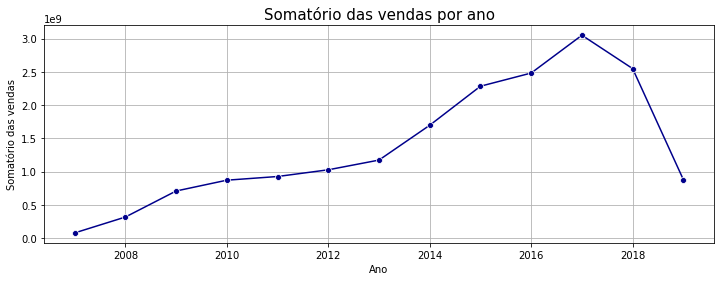

In [ ]:
# somatório das vendas por ano
sum_by_year = sales.groupby('Year').agg({'Price': 'sum'}).Price

plt.figure(figsize = (12, 4))
sns.lineplot(x = sum_by_year.index, y = sum_by_year, color = 'darkblue', marker = 'o')
plt.title('Somatório das vendas por ano', fontsize = 15)
plt.xlabel('Ano')
plt.ylabel('Somatório das vendas')
plt.show()

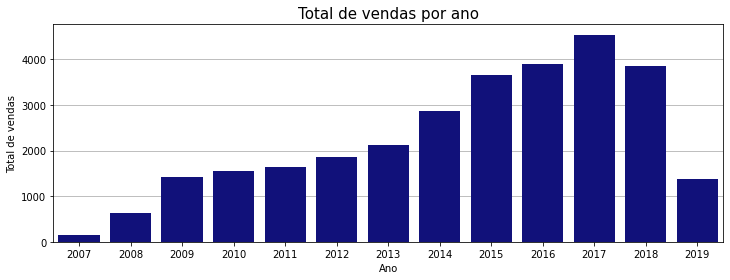

In [ ]:
# numero de vendas por ano
sales_by_year = sales.Year.value_counts(sort = False, ascending = False)

plt.figure(figsize = (12, 4))
sns.barplot(x = sales_by_year.index, y = sales_by_year, order = sales_by_year.index.sort_values(), color = 'darkblue')
plt.title('Total de vendas por ano', fontsize = 15)
plt.xlabel('Ano')
plt.ylabel('Total de vendas')
plt.show()

In [ ]:
# quantidade de vendas e somatório total por ano

total_sales_sum = pd.DataFrame([sales_by_year, sum_by_year], index = ['Count', 'Sum']).T.sort_index()
total_sales_sum.loc['Total', :] = total_sales_sum.sum(axis = 0)
total_sales_sum.astype(int)

,Count,Sum
2007,147,76789450
2008,639,315547250
2009,1426,707427239
2010,1555,870123280
2011,1633,925445775
2012,1858,1026547544
2013,2119,1172689133
2014,2863,1696767719
2015,3648,2284017698
2016,3908,2482304198


No prazo de 2007 a 2019 houve um total de **29580** produtos vendidos, cuja soma arrecadou um pouco mais de **18 bilhões** de unidades monetárias. É possível perceber uma tendência de crescimento nas vendas desde o ano de 2007 até 2017, com uma leve queda em 2018. Uma explicação para esta queda talvez seja uma elevação nos processos burocráticos criados pelos Vogons que causaram uma dificuldade de acesso aos produtos dentro da galáxia (desagradáveis mesmo). Vale ressaltar que o anos de 2019 não foi finalizado nesse conjunto de dados, isso justifica a "queda" brusca a partir de 2018. 

<br>
<br>


## 4.2) Total de vendas por produto e planeta

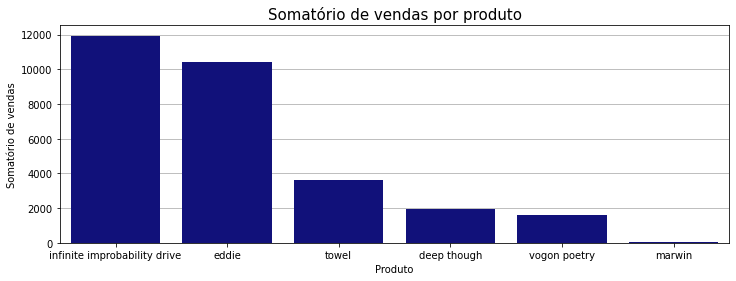

In [ ]:
sum_by_product = sales.groupby('product').agg({'Price': 'count'}).Price.sort_values(ascending = False)

plt.figure(figsize = (12, 4))
sns.barplot(x = sum_by_product.index, y = sum_by_product, color = 'darkblue')
plt.title('Somatório de vendas por produto', fontsize = 15)
plt.xlabel('Produto')
plt.ylabel('Somatório de vendas')
plt.show()

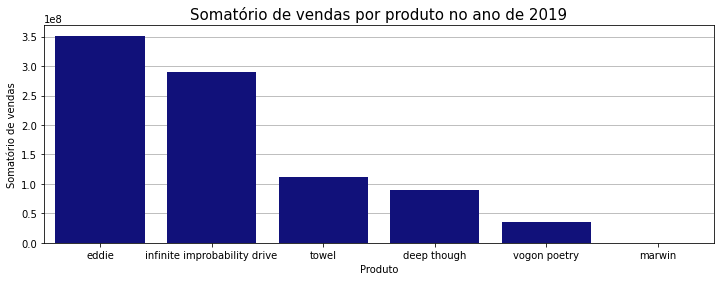

In [ ]:
# tomando as vendas de 2019
sum_by_product_2019 = sales[sales['Year'] == 2019].groupby('product').agg({'Price': 'sum'}).Price.sort_values(ascending = False)

plt.figure(figsize = (12, 4))
sns.barplot(x = sum_by_product_2019.index, y = sum_by_product_2019, color = 'darkblue')
plt.title('Somatório de vendas por produto no ano de 2019', fontsize = 15)
plt.xlabel('Produto')
plt.ylabel('Somatório de vendas')
plt.show()

In [ ]:
pd.DataFrame(sum_by_product_2019/sum_by_product_2019.sum()).reset_index().rename(columns = {'Price': 'revenue_product_proportion'})

,product,revenue_product_proportion
0,eddie,0.400295
1,infinite improbability drive,0.330237
2,towel,0.127489
3,deep though,0.101667
4,vogon poetry,0.039886
5,marwin,0.000426


Como podemos observar na tabela acima, o produto eddie é responsável por 40% da receita das vendas no ano de 2019, seguido pelo infinite improbability drive. Aparentemente muitas pessoas querem um robô triste para aconselhar ou viajar de forma mais dinâmica sem a chatice e complicação de atravessar o hiperespaço.

<br>
<br>

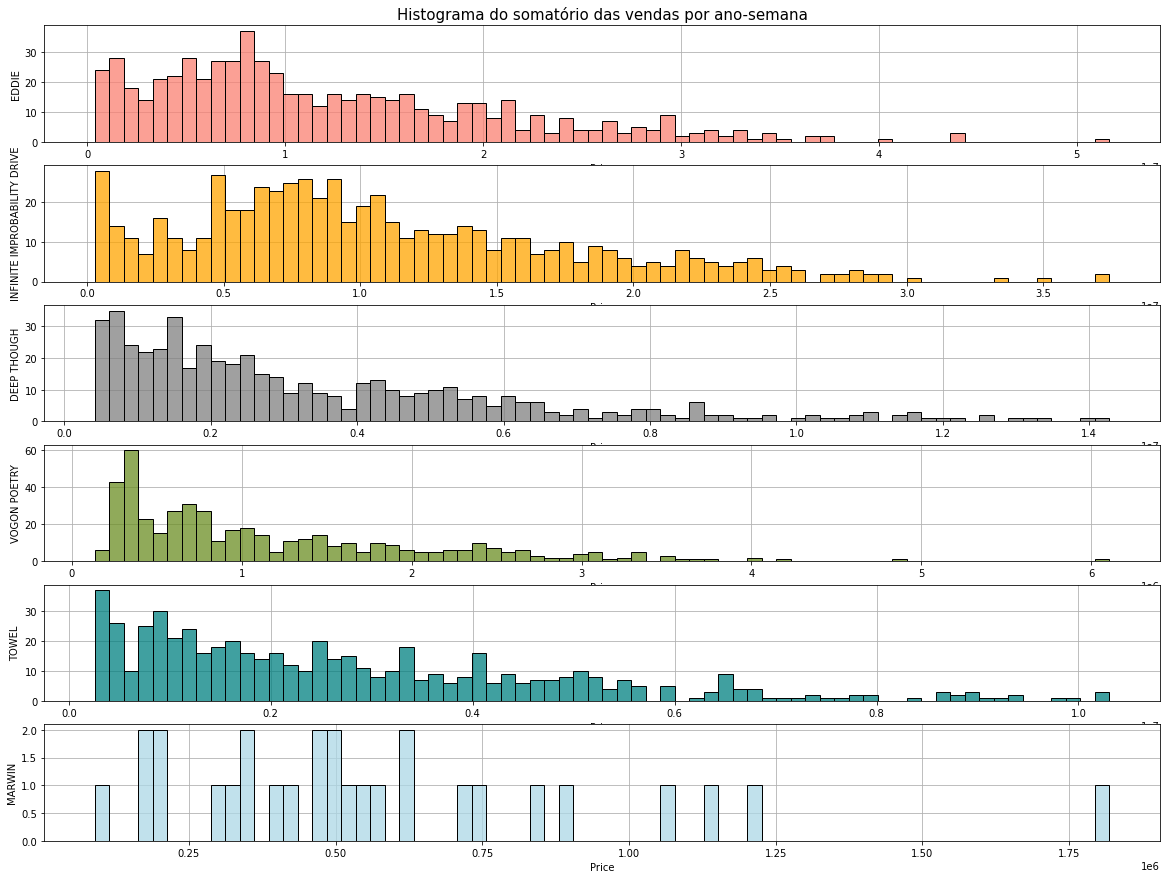

In [ ]:
# somatório das vendas por planeta e ano-semana
sales_by_product_year_week = sales.groupby(['product', 'Year_week']).agg({'Price': 'sum'}).reset_index()

fig, ax = plt.subplots(len(PRODUCTS), figsize = (20, 15))
for i, product, color in zip(range(len(PRODUCTS)), PRODUCTS, PRODUCTS_COLORS):
  sales_by_product = sales[sales['product'] == product].groupby(['Year_week']).agg({'Price': 'sum'})
  sns.histplot(data = sales_by_product.Price, ax = ax[i], bins = 70, color = color)
  ax[i].set_ylabel(product.upper())

ax[0].set_title('Histograma do somatório das vendas por ano-semana', fontsize = 15)
plt.show()

[]

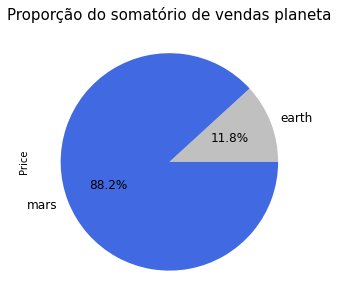

In [ ]:
sum_by_planet = sales.groupby('planet').agg({'Price': 'sum'}).Price

plt.figure(figsize = (5, 4))
sum_by_planet.plot.pie(
      autopct = '%.1f%%', 
    figsize = (5, 5), 
    colors = ['silver', 'royalblue'], 
    fontsize = 12
)

plt.title('Proporção do somatório de vendas planeta', fontsize = 15)
plt.plot()

[]

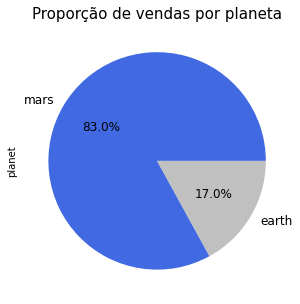

In [ ]:
sales.planet.value_counts().plot.pie(
    autopct = '%.1f%%', 
    figsize = (5, 5), 
    colors = ['royalblue', 'silver'], 
    fontsize = 12
)

plt.title('Proporção de vendas por planeta', fontsize = 15)
plt.plot()

Como podemos ver acima, o planeta Marte é responsável por 88.2% dos ganhos com as vendas. Em Marte também é onde se encontra o maior volume das vendas, cerca de 83% das vendas são realizadas direcionadas para marcianos.

In [ ]:
pd.crosstab(index = sales['product'], columns = sales['planet'], margins = True)

planet,earth,mars,All
product,,,
deep though,3,1947,1950
eddie,38,10404,10442
infinite improbability drive,652,11281,11933
marwin,11,19,30
towel,2792,806,3598
vogon poetry,1532,95,1627
All,5028,24552,29580


Acima temos a tabela cruzada que relaciona quantidade de vendas por produto e planeta. Podemos perceber que a demanda por *deep though* em Marte é 1947/3 = 649 vezes maior que no planeta Terra, podemos ver também uma alta na demanda pelo produto *eddie* (10494/3 = 273 vezes) também em Marte.

Porém, estes valores estão fortemente influenciados pela proporção de vendas, uma vez que a Terra é reponsável apenas por 17% delas. Para uma afirmação mais assertiva, seria necessário um balanceamento dos dados, por exemplo, aumentando a proporção de vendas no planeta Terra. 

Podemos perceber também que no planeta Terra existe uma demanda considerável de *vogon poetry*, mesmo com a despropoção de vendas em relação a Marte. Mas as afirmações acima tratam-se de suposições, seria necessário o cruzamento com outros dados e uma quantidade maior de registros.


In [ ]:
last_date_sell_by_product = sales.reset_index().groupby('product').agg({'Datetime': ['max']}).Datetime
last_date_sell_by_product['days_since_last_sale'] = sales.reset_index().Datetime.max() - last_date_sell_by_product['max']
last_date_sell_by_product

,max,days_since_last_sale
product,,
deep though,2019-07-27,0 days
eddie,2019-07-27,0 days
infinite improbability drive,2019-07-26,1 days
marwin,2019-07-05,22 days
towel,2019-07-26,1 days
vogon poetry,2019-07-25,2 days


Acima temos o último dia de venda de cada um dos produtos expresso na coluna *max*, ao lado temos o número de dias desde a compra mais recente no *dataframe*. Podemos ver que o produto *marwin* é um produto que talvez não seja essencial para qualquer um dos planetas tão quanto os demais.

<br>
<br>



## 4.3) Série temporal do total de vendas por planeta e produto  

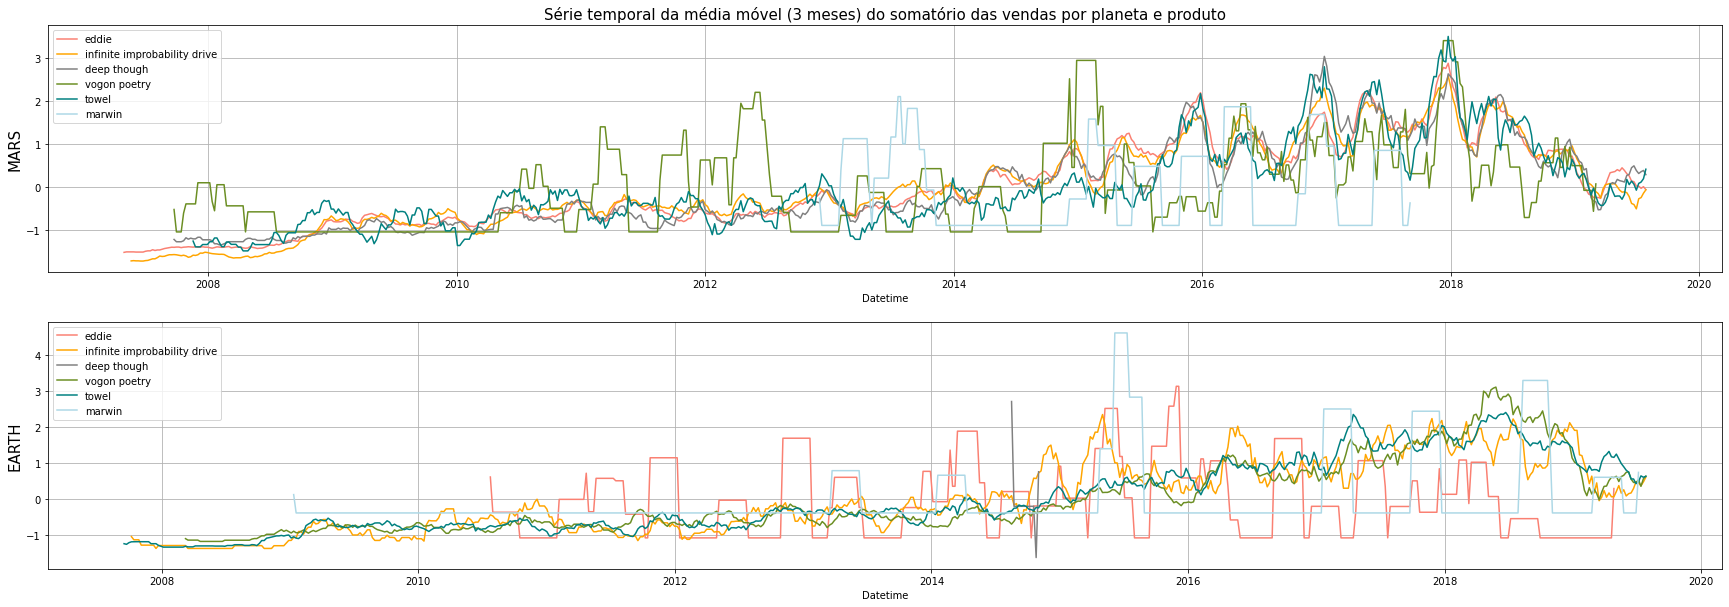

In [ ]:
# média móvel do somátório das vendas por planeta e ano-semana em um período de 7/7

fig, ax = plt.subplots(NUM_PLANETS, figsize = (30, 10))

for i, planet in enumerate(PLANETS):
  # separando por planeta
  sales_by_planet = sales[sales.planet == planet]

  for product, color in zip(PRODUCTS, PRODUCTS_COLORS):
    # separando por produto
    sales_by_planet_product = sales_by_planet[sales_by_planet['product'] == product]

    # tomando a média da soma das últimas 12 semanas (3 meses)
    sales_by_planet_product = sales_by_planet_product.resample(rule = 'W').Price.sum().rolling(12).mean().reset_index()

    # aplicando normalização (y(t) - E(Y))/σ(y)
    sales_by_planet_product.Price = (sales_by_planet_product.Price - sales_by_planet_product.Price.mean())/sales_by_planet_product.Price.std()

    # plotando o gráfico normalizado 
    sns.lineplot(data = sales_by_planet_product, x = 'Datetime', y = 'Price', ax = ax[i], color = color)
    ax[i].set_ylabel(planet.upper(), fontsize = 15)
    ax[i].legend(PRODUCTS, loc = 2)

ax[0].set_title('Série temporal da média móvel (3 meses) do somatório das vendas por planeta e produto', fontsize = 15)
plt.show()

Série temporal da soma total normalizada de vendas por planeta e produto. Decidi normalizar para que todas as vendas fiquem na mesma escala para que seja possível analisar e fazer um comparativo entre os produtos, uma vez que o desbalanceamento das vendas gera esta diferenciação na escala.

Mesmo com a normalização aplicada nas vendas de cada produto, ainda sim é difícil retirar algum insight deste gráfico.

<br>
<br>

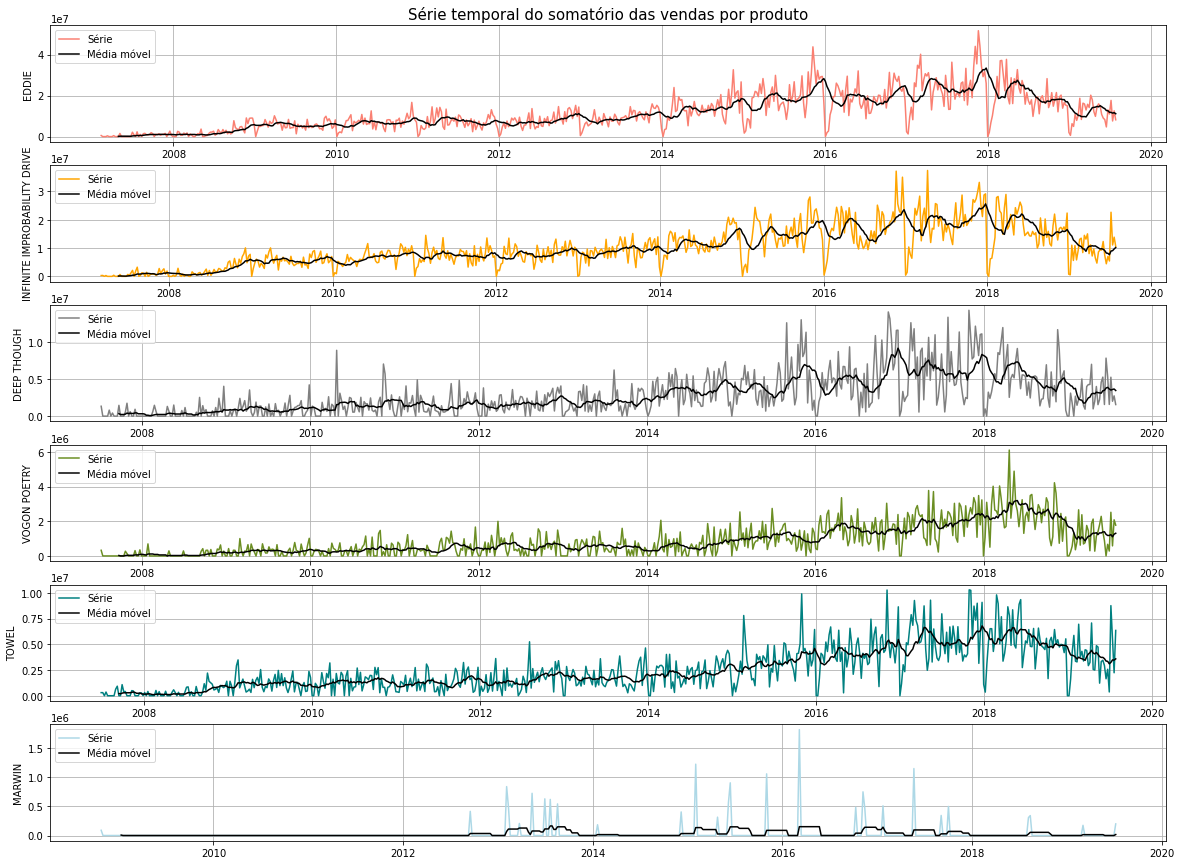

In [ ]:
fig, ax = plt.subplots(NUM_PRODUCTS, figsize = (20, 15))

for i, product, colors in zip(range(NUM_PRODUCTS), PRODUCTS, PRODUCTS_COLORS):
  product_sales = sales[sales['product'] == product].resample(rule = 'W').sum().Price
  mean_12_product_sales = product_sales.rolling(12).mean()
  ax[i].plot(product_sales, color = colors)
  ax[i].plot(mean_12_product_sales, color = 'black')
  ax[i].set_ylabel(product.upper())
  ax[i].legend(['Série', 'Média móvel'], loc = 2)
  
ax[0].set_title('Série temporal do somatório das vendas por produto', fontsize = 15)
plt.show()

Veja que todos os produtos são voláteis quanto ao preço, é difícil manter uma constância ao longo do ano. Podemos inferir pelos gráficos acima que a perturbação está aumentando, a volatilidade dos preços tendem a crescer.

A linha escura indica a média móvel das últimas 12 semanas. Com isso podemos enxergar de uma forma um pouco mais clara a tendência. 

Outro ponto interessante é que podemos notar uma certa sazonalidade nas séries temporais acima, vamos nos aprofundar mais sobre isso em breve.

<br>
<br>

### 4.3.1) Teste de Estacionariedade
Para sabermos se uma série é estacionária, conforme **FREITAS; MARGARIDO; BARBOSA; FRANCA (2001, p.4)**, é necessário que se preencha **três requisitos básicos**: 

1.   Sua esperança (média) deve ser constante ao longo do tempo $(E(y)$ constante para todo $t$);
2.   Sua variância também seja invariante ao longo do tempo ($Var(y)$ para todo *t*);
3.   Por fim, a covariância da série temporal indica que a autocorrelação entre dois valores de $y$ tomados em dois tempos $t1$ e $t2$ dependem exclusivamente do intervalo doo tempo entre os dois valores e não da sua respectiva data ($Cov(y(t)$, $y(t + h)$) seja constante para todo $t$ diferente de $h$.

<br>
<br>

Mas antes, utilizaremos de *feature engineering* para obtermos um novo *dataframe* para que possamos analisar melhor a soma das vendas ao longo dos anos. A escala será semanal.

Esta nova tabela conterá as seguintes colunas:
*    **Year_week**: ano-semana, em formato %Y-%w.
*    **Sum**: soma das vendas;
*    **MA_Sum**: média móvel das 4 semanas anteriores da soma de vendas;
*    **Count**: número de vendas;
*    **MA_Count**: média móvel das 4 semanas anteriores do número de vendas.

<br>

Para nos auxiliar, utilizei o método pandas.Series.resample que reorganiza a série temporal pelo intervalo desejado, no caso eu atribuí no parâmetro *rule* a *string* 'W', ou seja, ele vai rearranjar toda série temporal semana por semana tomando o último dia de cada uma e preenchendo os desfalques.

In [ ]:
sales_by_year_week = sales.resample(rule = 'W').agg({'Price': 'sum', 'product': 'count'}).rename(columns = {'product': 'Count', 'Price': 'Sum'}).reset_index()
sales_by_year_week['MA_Count'] = sales_by_year_week.Count.rolling(4).mean()
sales_by_year_week['MA_Sum'] = sales_by_year_week.Sum.rolling(4).mean()
sales_by_year_week['Year_week'] = sales_by_year_week.Datetime.apply(lambda date: f'{date.year}-{date.week}')
sales_by_year_week.set_index('Datetime', inplace = True)
sales_by_year_week = sales_by_year_week[['Year_week', 'Sum', 'MA_Sum', 'Count', 'MA_Count']]
sales_by_year_week.head(10)

,Year_week,Sum,MA_Sum,Count,MA_Count
Datetime,,,,,
2007-02-11,2007-6,525000.0,NaN,1,NaN
2007-02-18,2007-7,0.0,NaN,0,NaN
2007-02-25,2007-8,0.0,NaN,0,NaN
2007-03-04,2007-9,290000.0,203750.0,1,0.50
2007-03-11,2007-10,708000.0,249500.0,2,0.75
2007-03-18,2007-11,0.0,249500.0,0,0.75
2007-03-25,2007-12,310000.0,327000.0,1,1.00
2007-04-01,2007-13,0.0,254500.0,0,0.75
2007-04-08,2007-14,465000.0,193750.0,1,0.50


[]

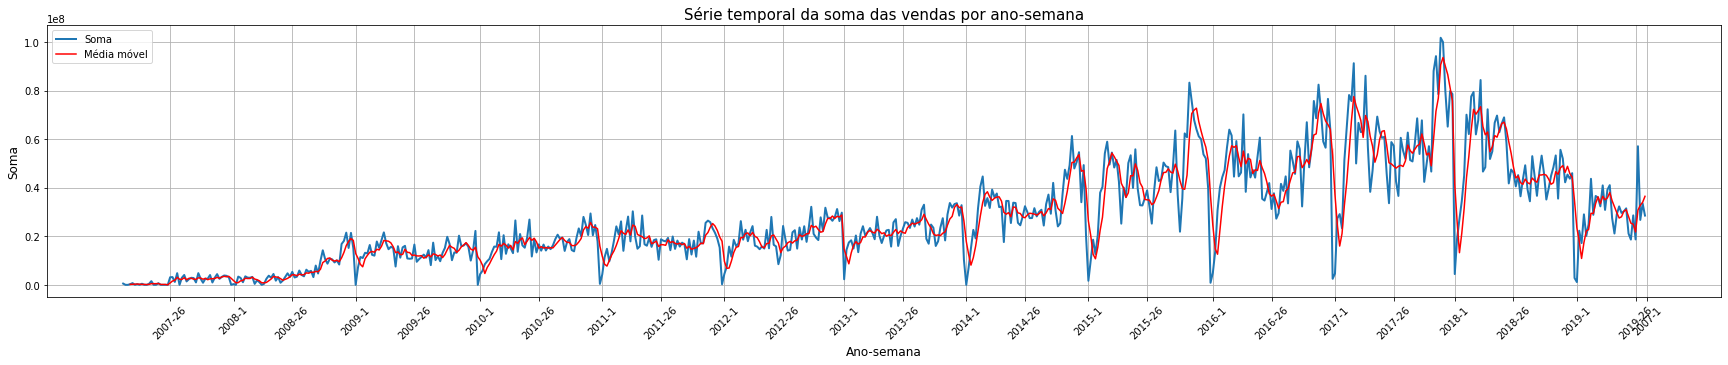

In [ ]:
plt.figure(figsize = (30, 5))
sns.lineplot(data = sales_by_year_week, x = 'Year_week', y = 'Sum', linewidth = 2)
sns.lineplot(data = sales_by_year_week, x = 'Year_week', y = 'MA_Sum', color = 'red')
plt.title('Série temporal da soma das vendas por ano-semana', fontsize = 15)
plt.ylabel('Soma', fontsize = 12)
plt.xlabel('Ano-semana', fontsize = 12)
plt.xticks(XTICKS, rotation = 45)
plt.legend(['Soma', 'Média móvel'], loc = 2)
plt.plot()

[]

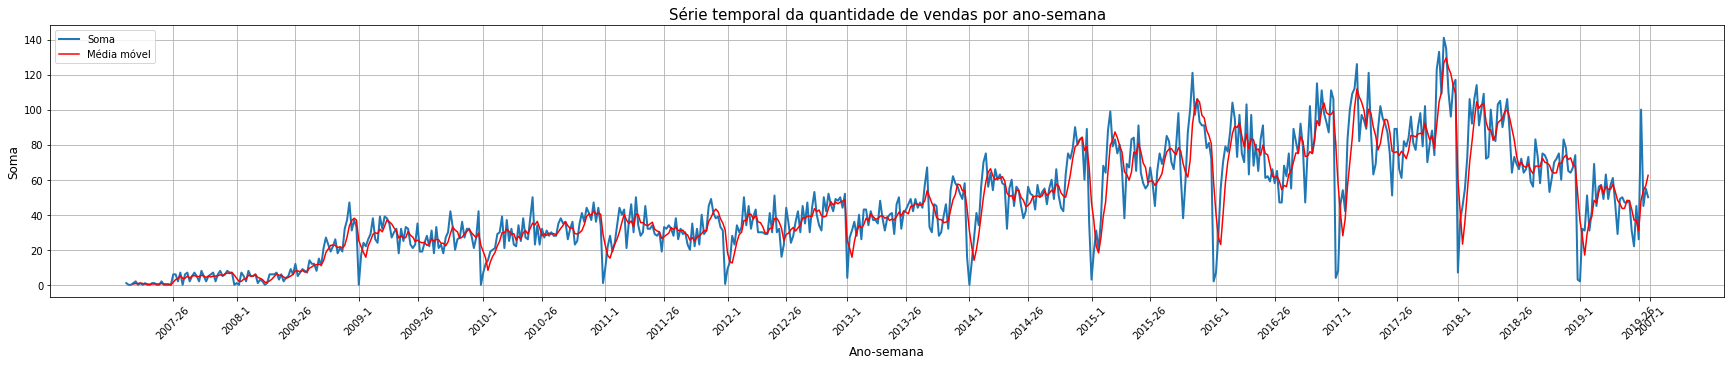

In [ ]:
plt.figure(figsize = (30, 5))
sns.lineplot(data = sales_by_year_week, x = 'Year_week', y = 'Count', linewidth = 2)
sns.lineplot(data = sales_by_year_week, x = 'Year_week', y = 'MA_Count', color = 'red')
plt.title('Série temporal da quantidade de vendas por ano-semana', fontsize = 15)
plt.ylabel('Soma', fontsize = 12)
plt.xlabel('Ano-semana', fontsize = 12)
plt.xticks(XTICKS, rotation = 45)
plt.legend(['Soma', 'Média móvel'], loc = 2)
plt.plot()

<br>
<br>

Existem outras maneiras para checar a estacionariedade de uma série, uma delas seria uma análise visual do gráfico que pode nos trazer alguns indícios de não-estacionaridade (como no nosso caso que apresenta uma tendência clara).


Uma outra maneira seria aplicar o **Teste de Dickey-Fuller** para verificar a estacionariedade de uma série temporal com nível de significância de 5%, caso o *p-valor* esteja acima de 0.05, aceitamos a hipótese nula, caso contrário, a rejeitamos: <br>
*    $H_0 \rightarrow$ A série tem uma raiz unitária e não é estacionária;
*    $H_1 \rightarrow$ A série não tem uma raiz unitária e é estacionária.

[]

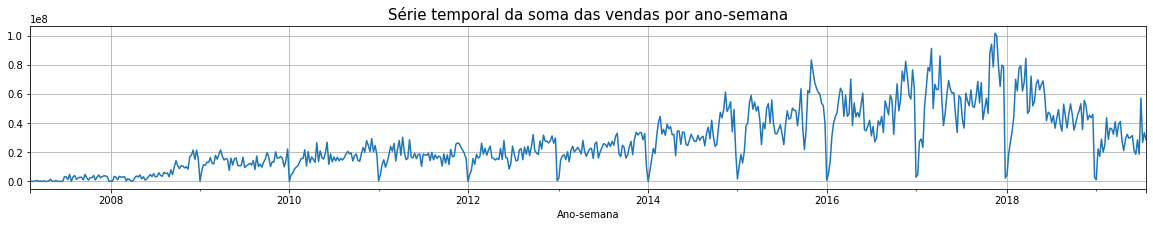

In [ ]:
plt.figure(figsize = (20, 3))
sales_by_year_week.Sum.plot.line()
plt.title('Série temporal da soma das vendas por ano-semana', fontsize = 15)
plt.xlabel('Ano-semana')
plt.plot()

In [ ]:
# aplicando teste de dick-fuller (série acima)

print('p-valor do teste:', adfuller(sales_by_year_week.Sum)[1])

p-valor do teste: 0.4582058656827393


[]

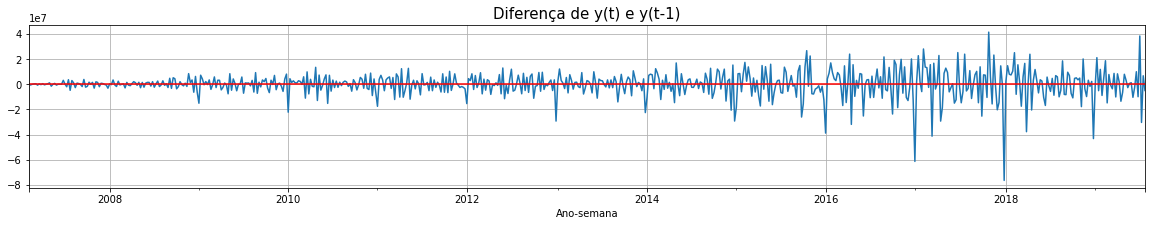

In [ ]:
# plotando a diferença de y(t) - y(t - 1), isso é feito pelo método diff do pandas.Series

plt.figure(figsize = (20, 3))
sales_by_year_week.Sum.diff().plot.line()
plt.axhline(sales_by_year_week.Sum.diff().mean(), c = 'red')
plt.title('Diferença de y(t) e y(t-1)', fontsize = 15)
plt.xlabel('Ano-semana')
plt.plot()

In [ ]:
# aplicando teste de dick-fuller com defasagem 1 (série acima)

print('p-valor do teste:', adfuller(sales_by_year_week.Sum.diff().dropna())[1])

p-valor do teste: 1.4460888026927293e-19


Como podemos observar, no primeiro gráfico é visível a tendência da série, então podemos inferir que há uma raiz unitária. Além disso, com o teste aplicado em seguida, podemos ver que o p-valor (0.4582) está acima de 0.05, ou seja, aceitamos a hipótese nula e podemos afirmar com 95% de confiança que a série não é estacionária.

<br>

Diferente do gráfico seguinte, onde é feita a diferença com a defasagem 1 da série, fazendo com que a série torne-se estacionária. Neste caso, o p-valor do teste é quase nulo, ou seja, rejeitamos a hipótese nula, aceitamos a alternativa e inferimos que, com uma confiança significativa, a série é estacionária.

Obs: a linha vermelha serve como referência para melhor compreesão do que é uma série estacionária.

<br>
<br>


### 4.3.2) Decomposição de uma Série Temporal

A decomposição é fruto da fórmula abaixo, caso você aplique o método aditivo:

$y_t = T_t + C_t + S_t + I_t$

onde,<br>
$y_t$ é o valor da série no tempo $t$;<br>
$T_t$ é a tendência, responsável por refletir a progressão ao longo do tempo;<br>
$C_t$ é o componente ciclo, que traduz repetições de longo prazo, flutuações essas que dependem da natureza da série temporal;<br>
$S_t$ a variável sazonalidade, parcela responsável pela peridiocidade da série.<br> 
$I_t$ o resíduo, ou ruído, no tempo $t$ que vêm de eventos aleatórios, influências externas, o resto das decomposições anteriores.<br>

<br>
<br>

Podemos perceber, então, que a soma dessas componentes gera o valor da série no tempo $t$. Ao aplicarmos a técnica de decomposição pelo método aditivo, chegamos em alguns resultados interessantes.

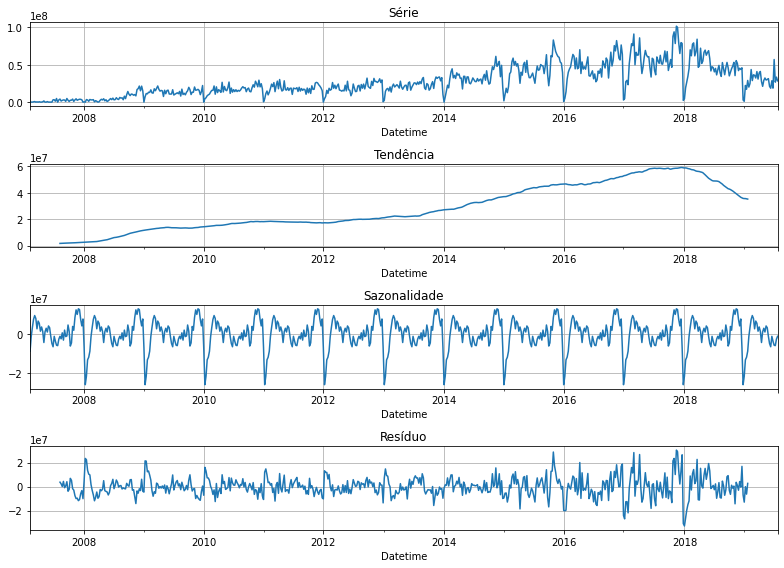

In [ ]:
# aplicando a decomposição com o seasonal_decompose
result = seasonal_decompose(sales_by_year_week.Sum)

fig, ax = plt.subplots(4, 1, figsize = (11, 8))
result.observed.plot(ax = ax[0])
ax[0].set_title('Série')
result.trend.plot(ax = ax[1])
ax[1].set_title('Tendência')
result.seasonal.plot(ax = ax[2])
ax[2].set_title('Sazonalidade')
result.resid.plot(ax = ax[3])
ax[3].set_title('Resíduo')
plt.tight_layout()

Acima temos as decomposição da soma das vendas ao longo do tempo, o primeiro é a série propriamente dita, seguida pela tendência, sazonalidade e resíduo. 

Como é possível vermos, o somatório de preços por semana apresenta uma tendência determinística até o final de 2018, quando inicia um processo de queda nas vendas. Vale ressaltar que não temos os dados completos de 2019, então seria necessário finalizar este ano para realmente termos maior clareza do relatório final.

Também podemos enxergar a sazonalidade da série: temos um aumento considerável nas vendas no fim do ano, seguido de queda bruta. Faz sentido, uma vez que as datas comemorativas iniciam-se no final do ano e acabam no inicio do próximo.

<br>
<br>

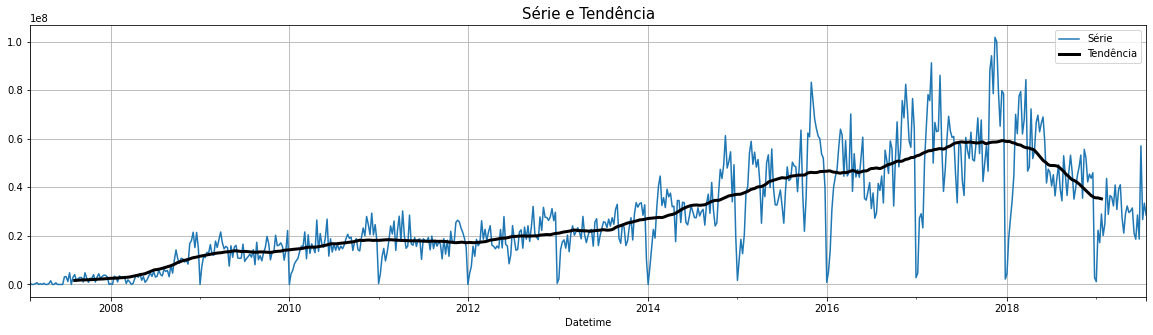

In [ ]:
plt.figure(figsize = (20, 5))
result.observed.plot()
result.trend.plot(color = 'black', linewidth = 3)
plt.title('Série e Tendência', fontsize = 15)
plt.legend(['Série', 'Tendência'])
plt.show()

### 4.3.3) Autocorrelação

Na Estatística existe o conceito de **correlação** entre duas variáveis. A correlação é responsável por nos dizer o quando uma variável se relaciona com a outra, podendo variar de -1 a 1: 
*    Quando mais próximo de -1, as variáveis possuem uma correlação negativa, ou seja, se a variável $a$ aumenta, então $b$ diminui;
*    Quando próximo a 0, então $a$ e $b$ não possuem correlação, uma não influencia na outra;
*    Quando mais próximo de 1, as variáveis possuem uma correlação positiva, ou seja, se $a$ e $b$ crescem ou diminuem juntas.

A correlação pertence ao intervalo que vai de -1 a 1, ou seja, $Corr(a, b) \in [-1, 1]$. Podemos definir sua potência, a fim de facilitar a compreensão, da seguinte forma: 
*    Se $|Corr(a, b)| \in [0, 0.4) \space\space\space \rightarrow $ dizemos que é uma correlação **fraca**;
*    Se $|Corr(a, b)| \in [0.4, 0.7) \rightarrow $ dizemos que é uma correlação **moderada**;
*    Se $|Corr(a, b)| \in [0.7, 1] \space\space\space \rightarrow $ dizemos que é uma correlação **forte**.

Uma parte importante é que **correlação não implica em causalidade**. É sempre bom deixar isso claro para evitar suposições e inferências incorretas acerca das variáveis estudadas.

<br>

Compreendido este conceito, temos a **autocorrelação** que, como o próprio nome diz, é a correlação da variável $a$ com ela mesma, no nosso caso, é a correlação da série temporal com alguma variação dela mesma. No caso abaixo, faremos a autocorrelação da série acima com *lags* anteiores.

In [ ]:
# autocorrelação da série temporal com lag 1, calculada pelo método pandas.Series.autocorr
sales_by_year_week.Sum.autocorr()

0.8769155744304373

Veja que a autocorrelação do preço do produto com a semana anterior é uma correlação de 0.8769, ou seja, é uma **autocorrelação fortemente positiva**, sendo assim temos um indício que o dia anterior pode sim afetar, de forma relativamente forte, o preço atual do produto.

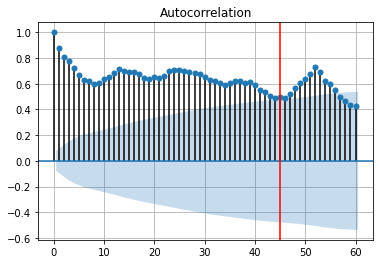

In [ ]:
plot_acf(sales_by_year_week.Sum, lags = 60, alpha = 0.05)
plt.axvline(45, color = 'red')
plt.show()

Para interpretar o gráfico logo acima, é necessário comprender algumas coisas: 
*    A área rachurada é o nível de confiança com valor padrão de 95% (valor crítico de 0.05);
*    Quando os pontos estiverem dentro da área rachurada, significa que não há uma correlação significativa entre $y(t)$ e $y(t-i)$;
*    As linhas verticais são as defasagens dos valores anteriores, os *lags*.

<br>

Após esta breve explicação, podemos inferir que a autocorrelação vai perdendo força ao longo do tempo (como esperado). Mas, o preço em $y(t)$ é influenciado por quantas semanas? Podemos observar pelo gráfico que o preço de venda de $y(t)$ é influenciado significativamente pelos preços de venda de até ~45 semanas atrás. 


Contudo, um fato interessante é temos uma elevação na autocorrelação antes de ela mergulhar dentro da área do nível de confiança, isso valeria ser investigado.


Podemos notar também o aspecto sinuoso da queda da correlação, isso é mais um indício de sazonalidade na variável.

<br>
<br>

Mas o problema da autocorrelação é que ela é acumulativa: o preço de $y(t)$ é influenciado por $y(t-1)$, este que é influenciado por $y(t-2)$ e assim sucessivamente, ou seja, $y(t)$ sofre com os resíduos acumulados pelos Lags anteriores... Para resolver isso, olhamos para a autocorrelação parcial que busca tratar este problema de resíduo acumulativo. Observe abaixo que a autocorrelação parcial acusa que $y(t)$ é influenciado até para $t\leq3$, e depois em outros intervalos que estão maiores que 3 (mais um indício de sazonalidade). Esta informação entrará na construção do nosso modelo preditivo.

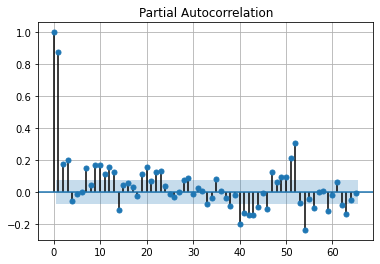

In [ ]:
plot_pacf(sales_by_year_week.Sum, lags = 65, alpha = 0.05)
plt.show()

### 4.3.4) Correlação entre os produtos

In [ ]:
# soma das vendas de cada produto por semana para realizar a correlação entre eles
products_ts = {}
for product in PRODUCTS:
  products_ts[product] = sales[(sales.Year == 2018) & (sales['product'] == product) & (sales.planet == 'mars')].Price.resample(rule = 'W').sum()

products_ts = pd.DataFrame(products_ts)
products_ts.head(10)

,eddie,infinite improbability drive,deep though,vogon poetry,towel,marwin
Datetime,,,,,,
2018-01-07,2050000.0,NaN,980000.0,NaN,NaN,NaN
2018-01-14,6770500.0,5185755.0,0.0,NaN,1230000.0,NaN
2018-01-21,10186500.0,6404500.0,3237000.0,NaN,795500.0,NaN
2018-01-28,15176000.0,8171500.0,2393500.0,NaN,0.0,NaN
2018-02-04,18471500.0,12332000.0,3248000.0,300000.0,1060000.0,NaN
2018-02-11,28815000.0,25012000.0,4500000.0,148000.0,480000.0,NaN
2018-02-18,19950500.0,26240259.0,5731000.0,0.0,832500.0,NaN
2018-02-25,36989892.0,20425000.0,5010000.0,0.0,4648000.0,NaN
2018-03-04,37167750.0,19672000.0,8562000.0,0.0,2757500.0,NaN


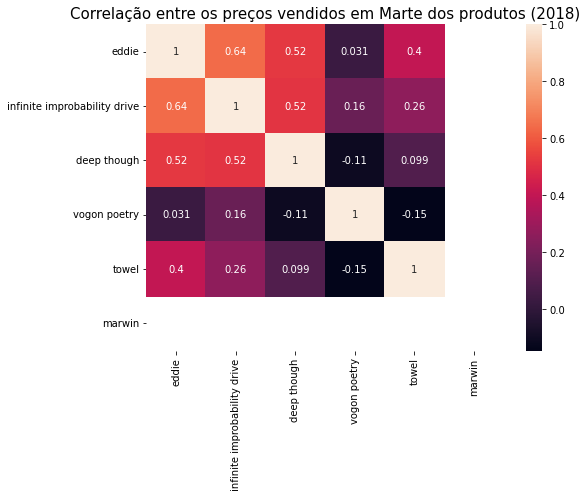

In [ ]:
plt.figure(figsize = (8, 6))
corrs_products = products_ts.corr()
sns.heatmap(corrs_products, annot = True)
plt.title('Correlação entre os preços vendidos em Marte dos produtos (2018)', fontsize = 15)
plt.show()

Neste gráfico foi plotado a correlação entre os produtos para entendermos a interdependência entre eles. Devemos tomar cuidado quanto ao balanceamento de vendas, nem todos os produtos são vendidos no mesmo dia para ser executada uma matriz de correlação mais confiável, mas acima podemos ver as **correlações positivas moderadas** entre *eddie* e *infinite improbability drive* e entre *eddie* e *deep though*. Seria necessário uma análise mais produnda para checar uma possível ligação ou dependência entre estas vendas, será que é necessário ter um *eddie* para ter um *infinite improbability drive*? Será que um é o complemento de outro? Por que as pessoas compram ambos juntos? Talvez sejam produtos que geram uma dependência mútua? Estas são algumas perguntas que poderiam ser feitas dado o heatmap acima.

Mas de forma geral, podemos dizer que **não há uma interdependência muito forte entre os produtos** se assumirmos uma possível causalidade. Isso pode ser que seja uma característica de séries temporáis de vendas.

## 4.4) Total de vendas de Deep Though em Marte entre 2015-20 e 2018-22

In [ ]:
mars_deep_thought = sales[(sales.planet == 'mars') & (sales['product'] == 'deep though')]
mars_deep_thought = mars_deep_thought[(mars_deep_thought.logical_Year_week >= 201520) & (mars_deep_thought.logical_Year_week <= 201822)]
mars_deep_thought.geocode.count()

906

Dentro do período requisitado, houveram 906 vendas em Marte do produto Deep Though entre a vigésima semana de 2015 e vigésima segunda semana de 2018.
<br>
<br>

# 5) Time Series Forecasting

Nesta seção utilizaremos o ARIMA para tentar predizer algumas séries baseado nos dados que foram fornecidos. Vale ressaltar que o algoritmo ARIMA não é necessariamente um modelo de machine learning, mas sim uma técnica estatística que utiliza de médias móveis e autocorrelações por ser um modelo linear.

Escolhi ele por ser um modelo bem conceituado quando se trata de séries estacionárias como a diferenciação da soma de vendas, além de ser rápido e de simples aplicação.

Abaixo há uma breve esquematização da técnica Hold *Out aplicada* na segmentação de dados para o treinamento de modelos de séries temporais, que consiste em particionar os dados de treino e teste conservando a característica fundamental de uma série: o **tempo**.

<br>

<img src="https://user-images.githubusercontent.com/56659549/141601357-2c0908ad-dc45-4962-b17c-2901af86fb27.png" width = 550>

In [ ]:
sales_by_year_week.head(5)

,Year_week,Sum,MA_Sum,Count,MA_Count
Datetime,,,,,
2007-02-11,2007-6,525000.0,NaN,1,NaN
2007-02-18,2007-7,0.0,NaN,0,NaN
2007-02-25,2007-8,0.0,NaN,0,NaN
2007-03-04,2007-9,290000.0,203750.0,1,0.50
2007-03-11,2007-10,708000.0,249500.0,2,0.75


<br>
<br>

O modelo ARIMA possui os seguintes parâmetros:
*    A autocorrelação significativa (gráfico de autocorrelação), onde tomamos quantos lags são significativos no preço;
*    O segundo parâmetro é a diferenciação, onde atribuímos 0 pois já estamos enviando os dados já diferenciados pelo método pandas.Series.diff;
*    O último parâmetro do *order* é a média móvel.

In [ ]:
# separando 90% para treino 
data_split_percentage = 0.90

# separando os dados e já fazendo a diferenciação
DATA_SPLIT = int(sales_by_year_week.shape[0] * data_split_percentage)
TRAIN = sales_by_year_week.Sum.diff().iloc[:DATA_SPLIT]
TEST = sales_by_year_week.Sum.diff().iloc[DATA_SPLIT - 1:]
TRAIN.size, TEST.size

'''
order = (AR, I, MA)
onde,
  AR é a autocorrelação
  I é a diferenciação
  MA é a média móvel
'''
model = ARIMA(TRAIN.dropna(), order = (5, 0, 1)).fit()

print(model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                    Sum   No. Observations:                  584
Model:                     ARMA(5, 1)   Log Likelihood              -10165.975
Method:                       css-mle   S.D. of innovations        8767347.337
Date:                Mon, 15 Nov 2021   AIC                          20347.950
Time:                        23:46:17   BIC                          20382.909
Sample:                    02-18-2007   HQIC                         20361.575
                         - 04-22-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.783e+04   2.27e+04      3.866      0.000    4.33e+04    1.32e+05
ar.L1.Sum      0.5823      0.041     14.066      0.000       0.501       0.663
ar.L2.Sum     -0.0275      0.047     -0.579      0.5

In [ ]:
print('Data máxima TRAIN:', str(TRAIN.index.max()))
print('Data mínima TEST:', str(TEST.index.min()))
print('Data máxima TEST:', str(TEST.index.max()))

Data máxima TRAIN: 2018-04-22 00:00:00
Data mínima TEST: 2018-04-22 00:00:00
Data máxima TEST: 2019-07-28 00:00:00


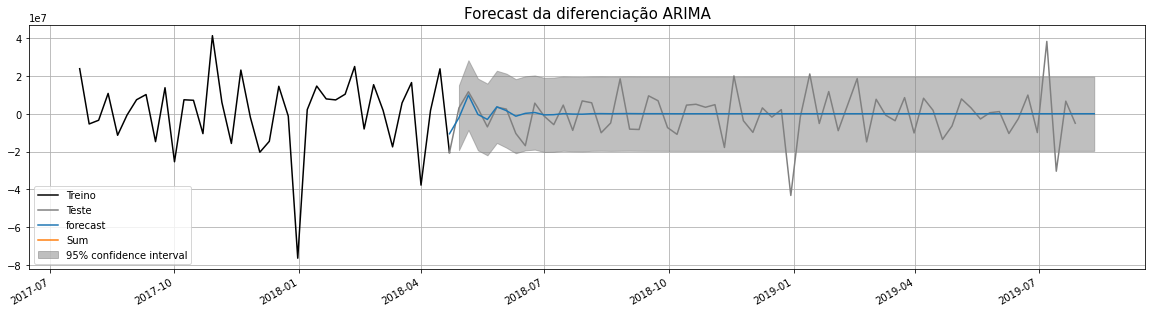

In [ ]:
fig, ax = plt.subplots(figsize = (20, 5))
ax.plot(TRAIN[-40:], label = 'Treino', color = 'black')
ax.plot(TEST, label = 'Teste', color = 'grey')
model.plot_predict(TEST.index.min(), '2019-08-11', ax = ax)
plt.legend(loc = 3)
plt.title('Forecast da diferenciação ARIMA', fontsize = 15)
plt.show()

In [ ]:
model.predict(TEST.index.min(), '2019-08-11')

2018-04-22   -1.052580e+07
2018-04-29   -2.015834e+06
2018-05-06    9.946720e+06
2018-05-13   -2.790991e+05
2018-05-20   -2.937870e+06
                  ...     
2019-07-14    8.783191e+04
2019-07-21    8.783083e+04
2019-07-28    8.782959e+04
2019-08-04    8.782845e+04
2019-08-11    8.782759e+04
Freq: W-SUN, Length: 69, dtype: float64

Um ponto importante que deve ser comentado é que os modelos de séries temporais foram construídos para predições curtas, acima podemos perceber isso. O modelo consegue predizer relativamente bem as próximas 4/5 semanas a partir da quarta semana de 2018, a partir disso ele já não consegue descrever de forma muito assertiva, como é perceptível ao olharmos a série de teste.

Para entendermos melhor este resultado do modelo, suponha que estívessemos no dia 2018-04-22 e que não conhecíamos os valores futuros (alaranjados), poderíamos supor, com certo grau de confiança, que na próxima semana haveria uma queda de -2.01e6 nas vendas, com um aumento de aproximadamente 10e6 na semana seguinte, com outra queda de -2.79e5. A partir desse ponto, não podemos supor com uma confiança alta os resultados do modelo ARIMA.

<br>
<br>

Existem algumas técnicas para melhorar os modelos através da avaliação do AIC, por exemplo. Também seria possível aplicar modelos de Deep Learning como o LSTM para uma tentativa mais robusta.